## 0. GPU 사용 가능 여부 확인

In [6]:
import torch
print(torch.cuda.is_available())

False


In [5]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12364090281161528455
 xla_global_id: -1]

## 1. 데이터 분할

### 1-1 .데이터 분할을 위한 폴더 생성

In [2]:
import os
import shutil

original_dataset_dir = 'D:/python_projects/deep-learning-with-projects/datasets/04_작물_잎_사진_질병_분류/dataset'   
classes_list = os.listdir(original_dataset_dir) 
 
base_dir = 'D:/python_projects/deep-learning-with-projects/datasets/04_작물_잎_사진_질병_분류/splitted' 
# os.mkdir(base_dir)                                1회만 실행
 
train_dir = os.path.join(base_dir, 'train') 
# os.mkdir(train_dir)                               1회만 실행
validation_dir = os.path.join(base_dir, 'val')
# os.mkdir(validation_dir)                          1회만 실행
test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)                                1회만 실행

for cls in classes_list:     
#     os.mkdir(os.path.join(train_dir, cls))        1회만 실행
#     os.mkdir(os.path.join(validation_dir, cls))   1회만 실행
#     os.mkdir(os.path.join(test_dir, cls))         1회만 실행

### 1-2. 데이터 분할과 클래스별 데이터 수 확인

In [3]:
import math
 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls) # dataset/~
    fnames = os.listdir(path) # dataset/~/~
 
    train_size = math.floor(len(fnames) * 0.6)
    validation_size = math.floor(len(fnames) * 0.2)
    test_size = math.floor(len(fnames) * 0.2)
    
    # Train 데이터
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames: 
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)
        shutil.copyfile(src, dst) # src(dataset/~/~)안에 있는 파일 내용을 dst(train 데이터 폴더) 경로로 복사

    # Validation 데이터
    validation_fnames = fnames[train_size:(validation_size + train_size)]
    print("Validation size(",cls,"): ", len(validation_fnames))
    for fname in validation_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(validation_dir, cls), fname)
        shutil.copyfile(src, dst)
        
    test_fnames = fnames[(train_size+validation_size):(validation_size + train_size +test_size)]

    # Test 데이터
    print("Test size(",cls,"): ", len(test_fnames))
    for fname in test_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(test_dir, cls), fname)
        shutil.copyfile(src, dst)

Train size( Apple___Apple_scab ):  378
Validation size( Apple___Apple_scab ):  126
Test size( Apple___Apple_scab ):  126
Train size( Apple___Black_rot ):  372
Validation size( Apple___Black_rot ):  124
Test size( Apple___Black_rot ):  124
Train size( Apple___Cedar_apple_rust ):  165
Validation size( Apple___Cedar_apple_rust ):  55
Test size( Apple___Cedar_apple_rust ):  55
Train size( Apple___healthy ):  987
Validation size( Apple___healthy ):  329
Test size( Apple___healthy ):  329
Train size( Cherry___healthy ):  512
Validation size( Cherry___healthy ):  170
Test size( Cherry___healthy ):  170
Train size( Cherry___Powdery_mildew ):  631
Validation size( Cherry___Powdery_mildew ):  210
Test size( Cherry___Powdery_mildew ):  210
Train size( Corn___Cercospora_leaf_spot Gray_leaf_spot ):  307
Validation size( Corn___Cercospora_leaf_spot Gray_leaf_spot ):  102
Test size( Corn___Cercospora_leaf_spot Gray_leaf_spot ):  102
Train size( Corn___Common_rust ):  715
Validation size( Corn___Commo

## 2. 베이스라인 모델 학습

### 2-1. 베이스라인 모델 학습을 위한 준비

In [5]:
import torch
import os
 
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

BATCH_SIZE = 256 
EPOCH = 30 

In [6]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
 
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()]) 
train_dataset = ImageFolder(root='D:/python_projects/deep-learning-with-projects/datasets/04_작물_잎_사진_질병_분류/splitted/train', transform=transform_base) 
val_dataset = ImageFolder(root='D:/python_projects/deep-learning-with-projects/datasets/04_작물_잎_사진_질병_분류/splitted/val', transform=transform_base)

In [7]:
from torch.utils.data import DataLoader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

### 2-2. 데이터 확인

In [8]:
print(len(train_dataset), len(val_dataset))

23989 7989


In [67]:
print("0번 데이터의 0번 원소 : ",train_dataset[0][0].shape)
print("0번 데이터의 1번 원소 : ", train_dataset[0][1])
print("0번 데이터의 Label : ", classes_list[ train_dataset[0][1] ])

0번 데이터의 0번 원소 :  torch.Size([3, 64, 64])
0번 데이터의 1번 원소 :  0
0번 데이터의 Label :  Apple___Apple_scab


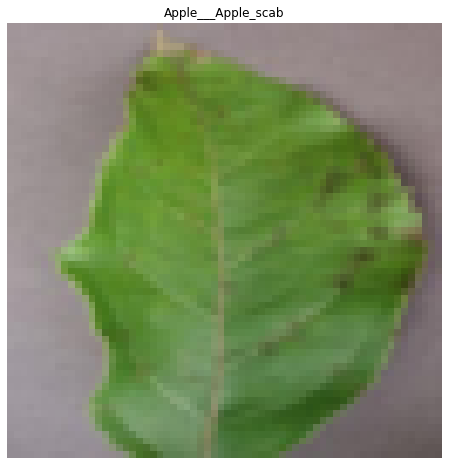

In [70]:
import matplotlib.pyplot as plt

image = train_dataset[0][0].permute(1,2,0)
label = classes_list[ train_dataset[0][1] ]

plt.figure(figsize=(8,8))
plt.axis('off')

plt.imshow(image)
plt.title(label)

plt.show()

In [93]:
first_batch = train_loader.__iter__().__next__()

print("총 batch의 수 :",len(train_loader), end="\n\n")
print("첫 번째 batch의 shape :", first_batch[0].shape, end="\n\n")
print("첫 번째 batch의 label (중간생략) :",first_batch[1][:10])

총 batch의 수 : 94

첫 번째 batch의 shape : torch.Size([256, 3, 64, 64])

첫 번째 batch의 label (중간생략) : tensor([30, 12,  3,  0,  8, 30,  4, 32, 25, 11])


In [94]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
class Net(nn.Module): 
  
    def __init__(self): 
    
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2,2)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)  

        self.fc1 = nn.Linear(4096, 512) 
        self.fc2 = nn.Linear(512, 33) 
    
    def forward(self, x):  
    
        x = self.conv1(x)
        x = F.relu(x)  
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training) 

        x = self.conv2(x)
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x) 
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1, 4096)  
        x = self.fc1(x) 
        x = F.relu(x) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x) 

        return F.log_softmax(x, dim=1)  

model_base = Net().to(DEVICE)  
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

In [95]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) 
        optimizer.zero_grad() 
        output = model(data)  
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()  

In [96]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data) 
            
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

In [ ]:
import time
import copy
 
def train_baseline(model ,train_loader, val_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        val_loss, val_acc = evaluate(model, val_loader)
        
        if val_acc > best_acc: 
            best_acc = val_acc 
            best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    model.load_state_dict(best_model_wts)  
    return model
 

base = train_baseline(model_base, train_loader, val_loader, optimizer, EPOCH)  	 #(16)
torch.save(base,'baseline.pt')